# Coin Seminar Plant Sleep Quality Regression

## Preparation

First of all the required packages need to be installed.

In [1]:
!pip install timm librosa torch torchvision tqdm torcheval cjm_pytorch_utils

Afterwards we will import all the required packages.

In [2]:
import random
import math
import multiprocessing
from pathlib import Path
import json

import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from PIL import Image
import torchaudio
from transformers import ASTFeatureExtractor

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.optim as optim

from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torcheval.metrics import R2Score
from cjm_pytorch_utils.core import  get_torch_device
from tqdm.notebook import tqdm
from google.colab import drive

In [3]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
# Move model to GPU if available
device = get_torch_device()

The notebook will be mounted to google drive to ensure persistent files for all sessions.

We will then select the directory, where all plant recordings and labels are saved.

In [5]:
%cd /kaggle/input/coin-data/COIN Projekt

/kaggle/input/coin-data/COIN Projekt


### Helper functions

We will use the following helper function to load and preprocess the audio data. The function will create a tuple of arrays containing the Mel Frequency Cepstral Coefficients, the values for the MEL Spectrograms, the filenames, and the associated subset.

In [6]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, subsets, hop_length=512, n_mels=128, n_mfcc=20, fmax = 20, n_fft=2048):
    """Loads and preprocesses audio data from specified directories.

    Args:
      data_dir: The directory containing the audio data.
      subsets: A list of subdirectories within `data_dir` to load data from.
      hop_length: The hop length to use when computing the Mel spectrogram.
      n_mels: The number of Mel frequency bins to use.

    Returns:
      A tuple containing:
        - A list of Mel spectrograms, one for each audio file.
        - A NumPy array of filenames corresponding to the Mel spectrograms.
        - A list of MFCCs, one for each audio file.
        - A list of subset names corresponding to the Mel spectrograms.
    """
    data = []
    filenames = []
    signals = []
    subset_names = []
    audio_dir = data_dir
    # We iterate through each subset
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        try:
          if filename.endswith('.wav'):
              file_path = os.path.join(subset_dir, filename) # joining the path to the subset and the filename to get the full path
              print(file_path)
              audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
              # Perform preprocessing (e.g., convert to Mel spectrogram)
              audio_signal = librosa.feature.mfcc(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mfcc=n_mfcc, fmax=fmax, n_fft=n_fft) # Extracting Mel Frequency Cepstral Coefficients
              mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, fmax=fmax, n_fft=n_fft) # Extracting  Mel spectrogram
              mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # We convert the amplitudes to decibel scale
              filenames.append(filename) # Saving the filenames in case we need it later
              subset_names.append(subset)
              signals.append(audio_signal)
              data.append(mel_spectrogram)
        except:
          pass
    return data, np.array(filenames), signals, subset_names

## Loading the data

We will load the labels separately as a Dataframe from the sleep circle data export. It is important to note that the datetime columns "Went to bed" and "Woke up" need to be converted to the datetime with the '%Y-%m-%d %H' format.

In [7]:
sleep_circle_dir = "./data/Labels/"
sleep_circle_dir

'./data/Labels/'

In [8]:
sleep_circle_data_list = []
for filename in os.listdir("./data/Labels/"):
  sleep__circle_data = pd.read_csv(os.path.join(sleep_circle_dir, filename), delimiter= ";")
  sleep__circle_data.rename(columns={"Start": "Went to bed", "End": "Woke up"}, inplace = True)
  sleep__circle_data["Went to bed"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Went to bed"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["Woke up"] =  pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["subset_name"] = filename.split(".csv")[0]
  sleep_circle_data_list.append(sleep__circle_data)
sleep_circle_df = pd.concat(sleep_circle_data_list)
sleep_circle_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Notes,subset_name,Asleep after (seconds),Snore time (seconds),Coughing (per hour),Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop
0,2024-10-14 23:00:00,2024-10-15 07:00:00,78%,0%,NaN,0.0,0.0,Normal,101.2,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-16 00:00:00,2024-10-16 08:00:00,71%,84%,NaN,0.0,0.0,Normal,100.8,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-17 00:00:00,2024-10-17 07:00:00,82%,85%,NaN,0.0,0.0,Normal,100.3,Köln,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-22 01:00:00,2024-10-22 09:00:00,84%,0%,NaN,0.0,0.0,Normal,101.2,Köln,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-23 00:00:00,2024-10-23 07:00:00,83%,75%,NaN,0.0,0.0,Normal,102.6,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2024-12-13 23:00:00,2024-12-14 07:00:00,65%,85%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,529.0,0.0,0.136085,NaN,NaN,NaN,NaN,NaN
39,2024-12-15 23:00:00,2024-12-16 07:00:00,86%,89%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,1089.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
40,2024-12-19 23:00:00,2024-12-20 07:00:00,91%,—,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,3234.0,31.0,0.474824,NaN,NaN,NaN,NaN,NaN
41,2024-12-20 23:00:00,2024-12-21 08:00:00,74%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,634.0,0.0,0.113422,NaN,NaN,NaN,NaN,NaN


In [9]:
sleep_circle_df["subset_name"].unique()

array(['Jasper', 'behrad', 'linus', 'Fynn'], dtype=object)

With the helper function we will load and preprocess the plant recordings.

In [10]:
hop_length=512
n_mels=30
n_mfcc=20*2
sr = 144
n_fft= 2048
mfcc = True
fmax = 20

In [11]:
data_dir = './data/Audio_Data'
subsets = ['behrad', 'linus', 'Jasper', 'Fynn']
audio_files, filenames, signals, subset_names  = load_and_preprocess_data(data_dir = data_dir, subsets = subsets, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, fmax = fmax, n_fft = n_fft)

./data/Audio_Data/behrad/behrad_142Hz_1729904937567.wav
./data/Audio_Data/behrad/behrad_142Hz_1731290866877.wav
./data/Audio_Data/behrad/behrad_142Hz_1730861279308.wav
./data/Audio_Data/behrad/behrad_142Hz_1734063115337.wav
./data/Audio_Data/behrad/behrad_142Hz_1729820420488.wav
./data/Audio_Data/behrad/behrad_142Hz_1731894532622.wav
./data/Audio_Data/behrad/behrad_142Hz_1736132158020.wav
./data/Audio_Data/behrad/behrad_142Hz_1730341004221.wav
./data/Audio_Data/behrad/behrad_142Hz_1731205560774.wav
./data/Audio_Data/behrad/behrad_142Hz_1736046241399.wav
./data/Audio_Data/behrad/behrad_142Hz_1730169214846.wav
./data/Audio_Data/behrad/behrad_142Hz_1731375736354.wav
./data/Audio_Data/behrad/behrad_142Hz_1730426561089.wav
./data/Audio_Data/behrad/behrad_142Hz_1731552619742.wav
./data/Audio_Data/behrad/behrad_142Hz_1729733764243.wav
./data/Audio_Data/behrad/behrad_142Hz_1731463744547.wav
./data/Audio_Data/behrad/behrad_142Hz_1731639615572.wav
./data/Audio_Data/behrad/behrad_142Hz_1729994749

From the filenames we extract the timestamp and convert it to the same format as the "Went to bed" column from the sleep circle data.

In [12]:
audio_timestamps = []
for filename in filenames:
  timestamp = filename.split("_")[-1]
  timestamp = timestamp.split(".")[0]
  timestamp = int(timestamp)
  timestamp = datetime.utcfromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H')
  audio_timestamps.append(timestamp)

We join the arrays to a single dataframe for easier use.

In [13]:
audio_df = pd.DataFrame(data = {"timestamp": audio_timestamps, "mel_spectrogram": audio_files, "mfcc": signals, "filenames": filenames, "subset": subset_names})
audio_df['timestamp'] = pd.to_datetime(audio_df['timestamp'])
audio_df

,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-26 01:00:00,"[[-9.2420845, -9.977047, -11.335073, -11.16693...","[[6.19677, -59.520477, -231.63171, -220.70311,...",behrad_142Hz_1729904937567.wav,behrad
1,2024-11-11 02:00:00,"[[0.0, -0.8089733, -2.22921, -2.3909454, -2.39...","[[22.55347, -43.656452, -219.40547, -216.82576...",behrad_142Hz_1731290866877.wav,behrad
2,2024-11-06 02:00:00,"[[1.9073486e-06, -0.87353134, -2.3591976, -2.2...","[[22.491035, -42.806576, -203.7815, -213.21837...",behrad_142Hz_1730861279308.wav,behrad
3,2024-12-13 04:00:00,"[[1.9073486e-06, -0.95363045, -2.4493923, -2.4...","[[18.20495, -48.079334, -215.43674, -203.25755...",behrad_142Hz_1734063115337.wav,behrad
4,2024-10-25 01:00:00,"[[-15.547953, -15.170078, -15.033655, -14.7028...","[[26.26631, -35.06353, -150.6705, -159.96912, ...",behrad_142Hz_1729820420488.wav,behrad
...,...,...,...,...,...
105,2024-10-27 22:00:00,"[[-18.123375, -18.065176, -18.622791, -19.8553...","[[22.441267, -33.520874, -120.43661, -165.3187...",fynn_142Hz_1730069702973.wav,Fynn
106,2024-10-23 21:00:00,"[[-18.906769, -19.519203, -22.005352, -17.8235...","[[39.473507, -25.947687, -101.78978, 26.244719...",fynn_142Hz_1729718185899.wav,Fynn
107,2024-10-29 22:00:00,"[[-0.3615055, -1.238081, -2.7095184, -2.690483...","[[31.007368, -35.165386, -247.81776, -236.8337...",fynn_142Hz_1730240668606.wav,Fynn
108,2024-11-24 22:00:00,"[[-0.21645737, -1.0631027, -2.5187263, -2.5476...","[[31.142927, -34.127357, -250.75967, -257.9536...",fynn_142Hz_1732487181377.wav,Fynn


We will sort the sleep circle data and the plant recording data to merge both dataframe with eachother.

In [14]:
sleep_circle_df = sleep_circle_df.sort_values("Went to bed")

audio_df = audio_df.sort_values('timestamp')

Because the plant recording starting time and the sleep circle timestamp sometimes do not match to the exact hour, we will merge both dataframes on the "Went to bed" column and the "timestamp" column with a range of 3 hours.

In [15]:
concat_arr = []
for subset in subsets:
  subset_df = audio_df[audio_df["subset"] == subset]
  sleep_circle_subset_df = sleep_circle_df[sleep_circle_df["subset_name"] == subset]
  subset_merged_df = pd.merge_asof(sleep_circle_subset_df, subset_df, left_on="Went to bed", right_on ="timestamp", direction='nearest', tolerance=pd.Timedelta('3 hour'))
  concat_arr.append(subset_merged_df)
merged_df = pd.concat(concat_arr)

We drop all rows which have null values for the mel_spectrogram. Furthermore we convert the sleep quality column to the float data type ranging from 0 to 1.

In [16]:
merged_df = merged_df.dropna(subset = ["mel_spectrogram"]).reset_index(drop=True)
merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", ""))/100)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", "")))
merged_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.889265, -19.23193, -20.274828, -20.40321...","[[5.601686, -58.546867, -188.5161, -198.8853, ...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.2420845, -9.977047, -11.335073, -11.16693...","[[6.19677, -59.520477, -231.63171, -220.70311,...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.030624, -18.87465, -21.061174, -21.60821...","[[30.924953, -35.603226, -195.11201, -161.1447...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.055973, -19.736286, -21.101559, -21.2340...","[[17.115925, -48.537975, -212.04088, -220.2908...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.89257, -19.266685, -20.113884, -18.22535...","[[-5.001769, -39.954525, -77.93218, -76.37371,...",behrad_142Hz_1730341004221.wav,behrad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2024-11-19 23:00:00,2024-11-20 08:00:00,0.90,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-19 22:00:00,"[[0.0, -0.8548565, -2.2779388, -2.282877, -2.2...","[[31.770903, -34.12682, -247.59358, -247.90414...",fynn_142Hz_1732056377456.wav,Fynn
98,2024-11-20 23:00:00,2024-11-21 08:00:00,0.89,94%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-20 22:00:00,"[[-2.2069607, -3.1631508, -4.5462856, -3.73286...","[[33.47163, -30.19658, -118.64306, -50.81634, ...",fynn_142Hz_1732143060447.wav,Fynn
99,2024-11-21 23:00:00,2024-11-22 08:00:00,0.94,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-21 22:00:00,"[[0.0, -0.8685074, -2.3048325, -2.3169022, -2....","[[30.774675, -35.16172, -267.83517, -260.1583,...",fynn_142Hz_1732228030045.wav,Fynn
100,2024-11-24 23:00:00,2024-11-25 08:00:00,0.89,99%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-24 22:00:00,"[[-0.21645737, -1.0631027, -2.5187263, -2.5476...","[[31.142927, -34.127357, -250.75967, -257.9536...",fynn_142Hz_1732487181377.wav,Fynn


In [17]:
merged_df[merged_df["subset"]== "behrad"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.889265, -19.23193, -20.274828, -20.40321...","[[5.601686, -58.546867, -188.5161, -198.8853, ...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.2420845, -9.977047, -11.335073, -11.16693...","[[6.19677, -59.520477, -231.63171, -220.70311,...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.030624, -18.87465, -21.061174, -21.60821...","[[30.924953, -35.603226, -195.11201, -161.1447...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.055973, -19.736286, -21.101559, -21.2340...","[[17.115925, -48.537975, -212.04088, -220.2908...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.89257, -19.266685, -20.113884, -18.22535...","[[-5.001769, -39.954525, -77.93218, -76.37371,...",behrad_142Hz_1730341004221.wav,behrad
5,2024-11-01 03:00:00,2024-11-01 09:00:00,0.61,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-01 02:00:00,"[[-16.990059, -18.433533, -19.535072, -18.7704...","[[23.032562, -16.991243, -64.29952, -62.16754,...",behrad_142Hz_1730426561089.wav,behrad
6,2024-11-02 03:00:00,2024-11-02 11:00:00,0.66,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-02 02:00:00,"[[-22.157078, -20.6092, -19.947767, -18.2203, ...","[[-52.449486, -74.89568, -87.8891, -90.986946,...",behrad_142Hz_1730513248148.wav,behrad
7,2024-11-03 03:00:00,2024-11-03 09:00:00,0.66,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 01:00:00,"[[0.0, -2.682331, -6.521694, -9.22151, -10.642...","[[156.23273, 90.265144, -104.22222, -156.63412...",behrad_142Hz_1730598993365.wav,behrad
8,2024-11-05 02:00:00,2024-11-05 11:00:00,0.84,86%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 01:00:00,"[[-0.17655945, -1.0672245, -2.4976254, -2.4943...","[[23.162321, -42.453625, -198.54251, -197.5576...",behrad_142Hz_1730770930651.wav,behrad
9,2024-11-06 03:00:00,2024-11-06 08:00:00,0.53,74%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 02:00:00,"[[1.9073486e-06, -0.87353134, -2.3591976, -2.2...","[[22.491035, -42.806576, -203.7815, -213.21837...",behrad_142Hz_1730861279308.wav,behrad


In [18]:
merged_df[merged_df["subset"]== "linus"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
24,2024-10-24 00:00:00,2024-10-24 08:00:00,0.86,91%,NaN,0.0,4919.0,Normal,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-23 22:00:00,"[[-1.9073486e-06, -0.90385246, -2.2878475, -2....","[[25.312414, -39.466778, -205.6329, -205.49686...",linus_142Hz_1729721787072.wav,linus
25,2024-10-29 01:00:00,2024-10-29 08:00:00,0.68,0%,NaN,0.0,1520.0,No alarm,100.1,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 00:00:00,"[[0.0, -0.8332882, -2.088997, -1.9928837, -1.9...","[[17.795994, -46.382908, -200.57074, -219.6148...",linus_142Hz_1730163250153.wav,linus
26,2024-10-30 00:00:00,2024-10-30 07:00:00,0.78,84%,NaN,0.0,1161.0,No alarm,100.2,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 23:00:00,"[[-1.3625107, -2.2210846, -3.6499348, -3.69405...","[[11.754186, -52.15469, -189.54837, -178.51076...",linus_142Hz_1730244394101.wav,linus
27,2024-10-31 00:00:00,2024-10-31 09:00:00,0.97,84%,NaN,0.0,5885.0,Normal,100.4,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-30 23:00:00,"[[-0.13281822, -0.976284, -2.375763, -2.382879...","[[18.39019, -46.981598, -233.30031, -234.49202...",linus_142Hz_1730330677318.wav,linus
28,2024-11-04 00:00:00,2024-11-04 07:00:00,0.83,0%,NaN,0.0,1249.0,No alarm,100.5,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 23:00:00,"[[-0.44874382, -1.2958336, -2.725851, -2.76712...","[[7.070914, -56.91038, -203.0163, -208.04755, ...",linus_142Hz_1730675179245.wav,linus
29,2024-11-05 00:00:00,2024-11-05 07:00:00,0.81,97%,NaN,0.0,2694.0,No alarm,100.0,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-04 23:00:00,"[[-2.055397, -2.9041443, -4.330801, -4.3277187...","[[7.86444, -56.740177, -212.57326, -211.85698,...",linus_142Hz_1730762836228.wav,linus
30,2024-11-06 00:00:00,2024-11-06 08:00:00,0.78,97%,NaN,0.0,2932.0,No alarm,100.2,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 23:00:00,"[[-1.412405, -2.3916073, -4.1157036, -4.320717...","[[-5.7285876, -68.383644, -217.89394, -226.354...",linus_142Hz_1730850110871.wav,linus
31,2024-11-07 00:00:00,2024-11-07 07:00:00,0.73,97%,NaN,0.0,0.0,No alarm,100.8,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 23:00:00,"[[-13.263283, -11.371965, -10.059898, -8.83913...","[[-96.927315, -145.57086, -217.90105, -207.257...",linus_142Hz_1730935108787.wav,linus
32,2024-11-07 23:00:00,2024-11-08 07:00:00,0.83,94%,NaN,0.0,4353.0,No alarm,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 22:00:00,"[[-7.927807, -8.838392, -6.517021, -3.7126389,...","[[-19.2847, -81.84112, -140.98784, -146.84837,...",linus_142Hz_1731018124056.wav,linus
33,2024-11-10 00:00:00,2024-11-10 08:00:00,0.86,84%,NaN,0.0,2804.0,No alarm,100.1,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-09 23:00:00,"[[-0.44335365, -1.3083076, -2.7522163, -2.8191...","[[14.102621, -51.16711, -228.26213, -201.73276...",linus_142Hz_1731195132023.wav,linus


In [19]:
merged_df = merged_df[merged_df["Went to bed"]<= "2024-11-22"].reset_index(drop=True)
merged_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.889265, -19.23193, -20.274828, -20.40321...","[[5.601686, -58.546867, -188.5161, -198.8853, ...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.2420845, -9.977047, -11.335073, -11.16693...","[[6.19677, -59.520477, -231.63171, -220.70311,...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.030624, -18.87465, -21.061174, -21.60821...","[[30.924953, -35.603226, -195.11201, -161.1447...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.055973, -19.736286, -21.101559, -21.2340...","[[17.115925, -48.537975, -212.04088, -220.2908...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.89257, -19.266685, -20.113884, -18.22535...","[[-5.001769, -39.954525, -77.93218, -76.37371,...",behrad_142Hz_1730341004221.wav,behrad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2024-11-17 23:00:00,2024-11-18 07:00:00,0.84,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-17 22:00:00,"[[-0.42045212, -1.2599697, -2.6761265, -2.6480...","[[31.166895, -34.8518, -254.13448, -236.91788,...",fynn_142Hz_1731883717724.wav,Fynn
69,2024-11-18 23:00:00,2024-11-19 07:00:00,0.82,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-18 22:00:00,"[[-0.012168884, -0.8626442, -2.2830677, -2.286...","[[31.059774, -34.831978, -240.42653, -239.8143...",fynn_142Hz_1731968098508.wav,Fynn
70,2024-11-19 23:00:00,2024-11-20 08:00:00,0.90,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-19 22:00:00,"[[0.0, -0.8548565, -2.2779388, -2.282877, -2.2...","[[31.770903, -34.12682, -247.59358, -247.90414...",fynn_142Hz_1732056377456.wav,Fynn
71,2024-11-20 23:00:00,2024-11-21 08:00:00,0.89,94%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-20 22:00:00,"[[-2.2069607, -3.1631508, -4.5462856, -3.73286...","[[33.47163, -30.19658, -118.64306, -50.81634, ...",fynn_142Hz_1732143060447.wav,Fynn


In [20]:
merged_df.columns

Index(['Went to bed', 'Woke up', 'Sleep Quality', 'Regularity', 'Mood',
       'Heart rate (bpm)', 'Steps', 'Alarm mode', 'Air Pressure (Pa)', 'City',
       'Movements per hour', 'Time in bed (seconds)', 'Time asleep (seconds)',
       'Time before sleep (seconds)', 'Window start', 'Window stop',
       'Did snore', 'Snore time', 'Weather temperature (°C)', 'Weather type',
       'Notes', 'subset_name', 'Asleep after (seconds)',
       'Snore time (seconds)', 'Coughing (per hour)', 'Alertness score',
       'Alertness reaction time (seconds)', 'Alertness accuracy',
       'Wake up window start', 'Wake up window stop', 'timestamp',
       'mel_spectrogram', 'mfcc', 'filenames', 'subset'],
      dtype='object')

## Visualizing the data

In [21]:
merged_df["mel_spectrogram"].shape

(73,)

In [22]:
merged_df["mel_spectrogram"][0]

array([[-18.889265, -19.23193 , -20.274828, ..., -19.335478, -19.805643,
        -17.166452],
       [-30.808277, -36.45265 , -46.487682, ..., -29.45359 , -41.900196,
        -31.53953 ],
       [-34.63925 , -40.283848, -50.38766 , ..., -36.006107, -47.189137,
        -35.640068],
       ...,
       [-53.44152 , -59.25374 , -76.392715, ..., -68.57826 , -72.00946 ,
        -54.698456],
       [-54.248283, -60.099564, -74.02176 , ..., -69.36964 , -72.44215 ,
        -54.97757 ],
       [-54.75049 , -59.65254 , -65.04536 , ..., -67.81531 , -65.16815 ,
        -55.50779 ]], dtype=float32)

In [23]:
np.abs(merged_df["mfcc"][0])

array([[5.6016860e+00, 5.8546867e+01, 1.8851610e+02, ..., 1.0651335e+02,
        1.6121724e+02, 5.3107624e+00],
       [7.9339104e+01, 7.9317551e+01, 6.8338226e+01, ..., 1.2427908e+02,
        8.6775284e+01, 7.8300163e+01],
       [2.9101280e+01, 3.1140663e+01, 4.4059830e+01, ..., 5.4240059e+01,
        5.5247009e+01, 3.2729332e+01],
       ...,
       [1.4882014e+00, 2.4119635e+00, 2.1226542e+00, ..., 9.2116947e+00,
        1.5715902e+00, 6.5454543e-01],
       [1.7411983e+00, 2.0291820e+00, 1.8078685e-02, ..., 9.6782532e+00,
        4.6854954e+00, 2.1046257e+00],
       [1.3948096e+00, 2.5751381e+00, 3.1232756e-01, ..., 1.4694111e+00,
        1.5741129e+00, 1.0369613e+00]], dtype=float32)

We plot the MEL-Spectrogram and the MFCC with the librosa.display.specshow function (https://librosa.org/doc/main/generated/librosa.display.specshow.html). All values are plotted in hz units but the scale differs (MEL-Spectrogram uses mel scale while MFCC uses hz).

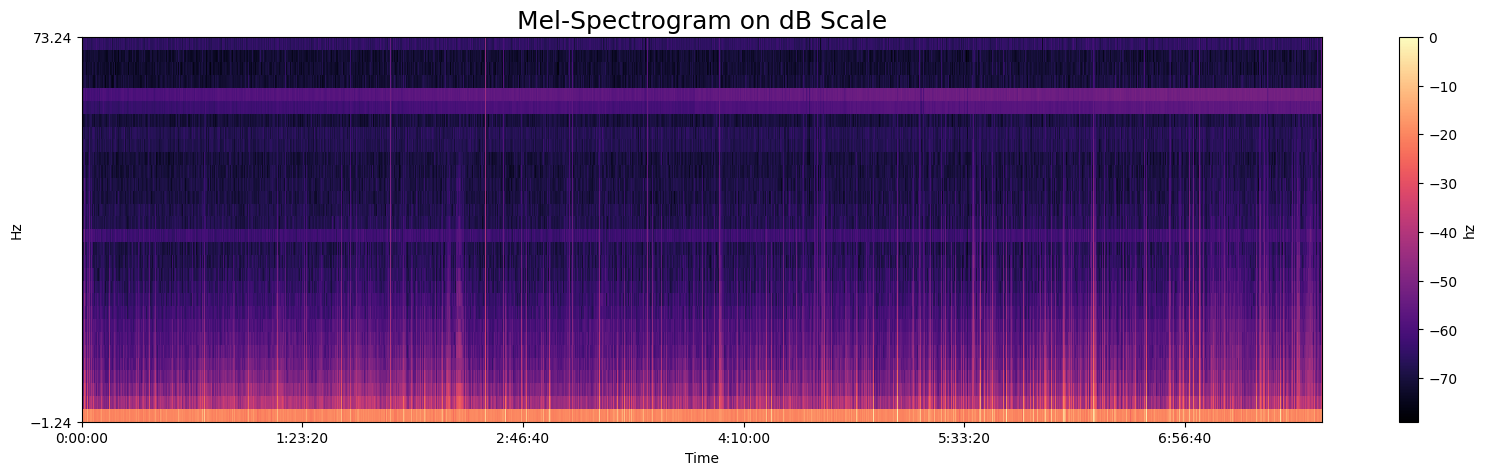

In [24]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df["mel_spectrogram"][0], x_axis='time',
                         y_axis='mel', sr=144, cmap= "magma", hop_length=512)
plt.colorbar(label="hz")
plt.title('Mel-Spectrogram on dB Scale', fontdict=dict(size=18))
plt.show()

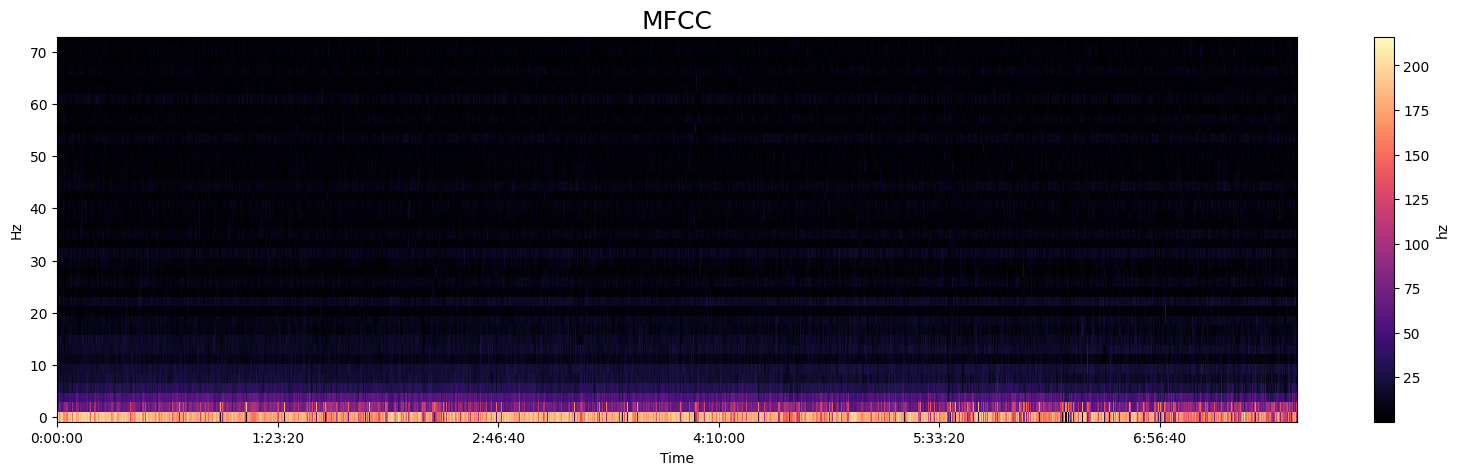

In [25]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(np.abs(merged_df["mfcc"][0]), x_axis='time',
                         y_axis = "hz", sr=144, cmap= "magma")
plt.colorbar(label = "hz")
plt.title("MFCC", fontdict=dict(size=18))
plt.show()

We will also visualize the waveform to look at the peaks of amiplitudes (https://librosa.org/doc/main/generated/librosa.display.waveshow.html).

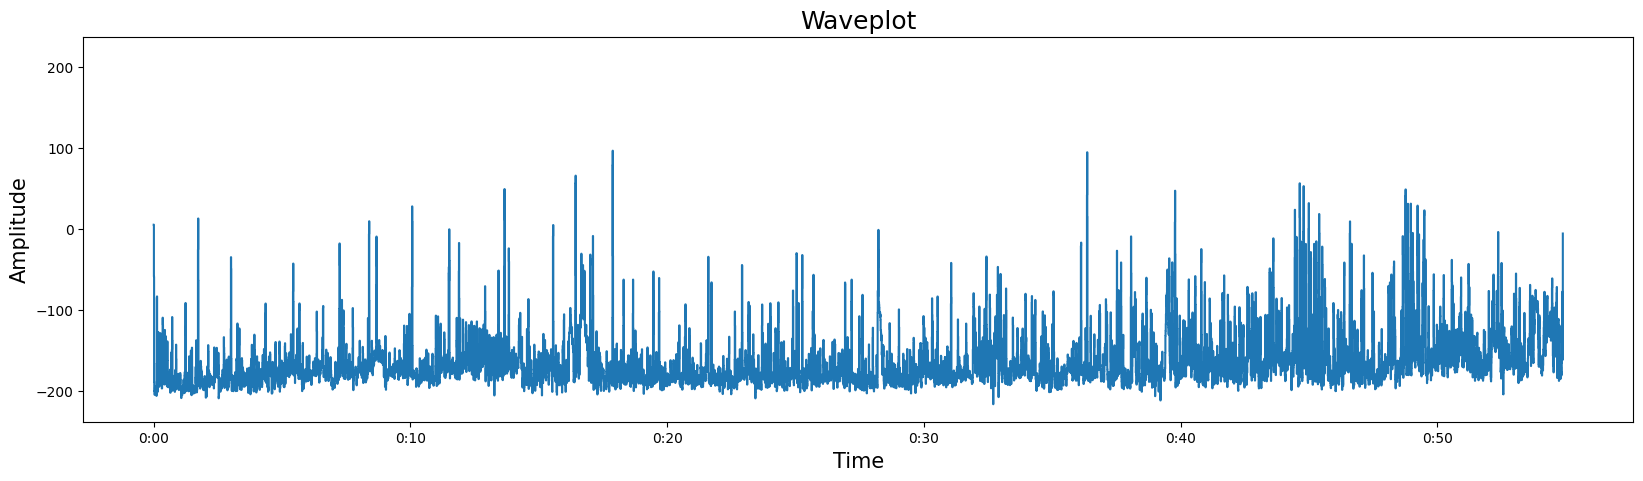

In [26]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(merged_df["mfcc"][0], sr = 144)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

## Training Image Classification Neural Networks

## Model loading

In [27]:
# Load a pretrained model from timm

#model = timm.create_model('resnet18', pretrained=True)
model = timm.create_model('eva02_base_patch14_448.mim_in22k_ft_in22k_in1k', pretrained=True, num_classes=1)
model

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-11): 12 x EvaBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=768, out_features=2048, bias=True)
        (fc1_x): Linear(in_features=76

In [28]:
model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k',
 'architecture': 'eva02_base_patch14_448',
 'tag': 'mim_in22k_ft_in22k_in1k',
 'custom_load': False,
 'input_size': (3, 448, 448),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'squash',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'license': 'mit'}

### Dataset

We create a custom dataframe object for the mfcc or the melspectrogram.

In [29]:
class AudioDataset(Dataset):
    def __init__(self, audio_data, labels, transform=None):
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        # Load mel spectrogram
        mel_spectrogram = np.dstack([self.audio_data[idx], self.audio_data[idx], self.audio_data[idx]])

        # Apply transforms if specified
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        label = self.labels[idx]

        return mel_spectrogram, label

# Define transform to convert numpy arrays to torch tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(model.pretrained_cfg["input_size"][1:]),  # Match input size expected by the model
    transforms.Normalize(mean=model.pretrained_cfg["mean"], std=model.pretrained_cfg["std"])
])

First we split the dataframe into train and validation set.

In [30]:
merged_df

#merged_df["Sleep Quality"] = (merged_df["Sleep Quality"]- merged_df["Sleep Quality"].abs().min())/ (merged_df["Sleep Quality"].abs().max() - merged_df["Sleep Quality"].abs().min())

train_df = merged_df.sample(frac=0.8, random_state=42)
val_df = merged_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.89257, -19.266685, -20.113884, -18.22535...","[[-5.001769, -39.954525, -77.93218, -76.37371,...",behrad_142Hz_1730341004221.wav,behrad
1,2024-11-11 19:00:00,2024-11-12 08:00:00,0.39,73%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-11 18:00:00,"[[-7.447155, -8.359484, -9.803741, -9.855703, ...","[[31.317198, -34.178844, -233.12299, -244.4498...",fynn_142Hz_1731350077682.wav,Fynn
2,2024-11-16 02:00:00,2024-11-16 10:00:00,0.63,7%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-16 01:00:00,"[[-19.587795, -20.404974, -18.834547, -13.5873...","[[16.928421, -44.364914, -121.03323, -97.58879...",behrad_142Hz_1731721964748.wav,behrad
3,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.889265, -19.23193, -20.274828, -20.40321...","[[5.601686, -58.546867, -188.5161, -198.8853, ...",behrad_142Hz_1729733764243.wav,behrad
4,2024-11-07 00:00:00,2024-11-07 07:00:00,0.73,97%,NaN,0.0,0.0,No alarm,100.8,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 23:00:00,"[[-13.263283, -11.371965, -10.059898, -8.83913...","[[-96.927315, -145.57086, -217.90105, -207.257...",linus_142Hz_1730935108787.wav,linus
5,2024-11-21 23:00:00,2024-11-22 08:00:00,0.94,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-21 22:00:00,"[[0.0, -0.8685074, -2.3048325, -2.3169022, -2....","[[30.774675, -35.16172, -267.83517, -260.1583,...",fynn_142Hz_1732228030045.wav,Fynn
6,2024-11-07 03:00:00,2024-11-07 11:00:00,0.88,70%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 01:00:00,"[[-15.512314, -15.458508, -17.185616, -18.7081...","[[49.138214, 3.6010368, -48.759315, -118.35828...",behrad_07-11-2024_02_51_09_142Hz_1730944269321...,behrad
7,2024-11-15 01:00:00,2024-11-15 07:00:00,0.50,91%,NaN,0.0,3179.0,No alarm,100.3,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-14 23:00:00,"[[-10.616108, -11.598499, -13.263508, -13.4577...","[[-90.87844, -134.19266, -187.5429, -173.41884...",linus_142Hz_1731627171218.wav,linus
8,2024-11-10 03:00:00,2024-11-10 10:00:00,0.71,95%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-10 02:00:00,"[[0.0, -1.6903, -13.61026, -24.051598, -22.925...","[[241.52112, 175.08505, -134.25493, -161.22893...",behrad_142Hz_1731205560774.wav,behrad
9,2024-10-29 23:00:00,2024-10-30 07:00:00,0.87,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 22:00:00,"[[-0.3615055, -1.238081, -2.7095184, -2.690483...","[[31.007368, -35.165386, -247.81776, -236.8337...",fynn_142Hz_1730240668606.wav,Fynn


In [31]:
val_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.2420845, -9.977047, -11.335073, -11.16693...","[[6.19677, -59.520477, -231.63171, -220.70311,...",behrad_142Hz_1729904937567.wav,behrad
1,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.030624, -18.87465, -21.061174, -21.60821...","[[30.924953, -35.603226, -195.11201, -161.1447...",behrad_142Hz_1729994749595.wav,behrad
2,2024-11-12 02:00:00,2024-11-12 10:00:00,0.76,94%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-12 01:00:00,"[[-0.28805733, -1.1506824, -2.6214485, -2.7374...","[[23.943611, -41.64061, -210.65112, -222.35014...",behrad_142Hz_1731375736354.wav,behrad
3,2024-11-18 02:00:00,2024-11-18 09:00:00,0.68,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-18 01:00:00,"[[-18.589027, -19.17283, -19.243618, -19.88368...","[[16.796627, -47.09517, -167.43387, -183.499, ...",behrad_142Hz_1731894532622.wav,behrad
4,2024-10-24 00:00:00,2024-10-24 08:00:00,0.86,91%,NaN,0.0,4919.0,Normal,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-23 22:00:00,"[[-1.9073486e-06, -0.90385246, -2.2878475, -2....","[[25.312414, -39.466778, -205.6329, -205.49686...",linus_142Hz_1729721787072.wav,linus
5,2024-10-30 00:00:00,2024-10-30 07:00:00,0.78,84%,NaN,0.0,1161.0,No alarm,100.2,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 23:00:00,"[[-1.3625107, -2.2210846, -3.6499348, -3.69405...","[[11.754186, -52.15469, -189.54837, -178.51076...",linus_142Hz_1730244394101.wav,linus
6,2024-11-07 23:00:00,2024-11-08 07:00:00,0.83,94%,NaN,0.0,4353.0,No alarm,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 22:00:00,"[[-7.927807, -8.838392, -6.517021, -3.7126389,...","[[-19.2847, -81.84112, -140.98784, -146.84837,...",linus_142Hz_1731018124056.wav,linus
7,2024-11-18 23:00:00,2024-11-19 07:00:00,0.91,80%,NaN,0.0,911.0,No alarm,98.3,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-18 22:00:00,"[[-13.736719, -14.757384, -16.258587, -16.0279...","[[-107.77884, -151.93211, -184.69319, -168.928...",linus_142Hz_1731968621195.wav,linus
8,2024-11-10 00:00:00,2024-11-10 10:00:00,0.84,74%,NaN,0.0,9055.0,Normal,101.8,Köln,...,NaN,NaN,NaN,NaN,NaN,2024-11-09 23:00:00,"[[-22.81745, -23.737238, -25.175121, -25.11202...","[[39.39456, -26.94149, -172.1473, -171.06482, ...",Jasper_142Hz_1731194512081.wav,Jasper
9,2024-10-23 23:00:00,2024-10-24 02:00:00,0.27,—,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-23 21:00:00,"[[-18.906769, -19.519203, -22.005352, -17.8235...","[[39.473507, -25.947687, -101.78978, 26.244719...",fynn_142Hz_1729718185899.wav,Fynn


In [32]:
train_df.merge(val_df, on=["filenames", "Sleep Quality"], how = "inner")

,Went to bed_x,Woke up_x,Sleep Quality,Regularity_x,Mood_x,Heart rate (bpm)_x,Steps_x,Alarm mode_x,Air Pressure (Pa)_x,City_x,...,Coughing (per hour)_y,Alertness score_y,Alertness reaction time (seconds)_y,Alertness accuracy_y,Wake up window start_y,Wake up window stop_y,timestamp_y,mel_spectrogram_y,mfcc_y,subset_y


In [33]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()#//2
batch_size = 4
# Define parameters for DataLoader
data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

In [34]:
# Instantiate the dataset
dataset_train = AudioDataset(audio_data=train_df["mfcc"], labels=train_df["Sleep Quality"], transform=transform)
dataset_val = AudioDataset(audio_data=val_df["mfcc"], labels=val_df["Sleep Quality"], transform=transform)

# Create a DataLoader
data_loader = DataLoader(dataset_train, **data_loader_params, shuffle=True)
data_loader_val = DataLoader(dataset_val, **data_loader_params, shuffle=False)

It is important to note that we are doing a regression task, therefore we need to change the last layer to have only one output feature.

### Model training

In [35]:
model = model.to(device)

In [36]:
def get_warmup_scheduler(optimizer, num_warmup_steps, total_steps):
    """
    Returns a scheduler with a linear warmup phase.

    :param optimizer: Optimizer to adjust the learning rate for.
    :param num_warmup_steps: Number of steps for the warmup phase.
    :param total_steps: Total number of training steps.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda)

In [37]:
class WarmupDecayScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=0, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        super(WarmupDecayScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        current_step = self.last_epoch + 1
        if current_step < self.warmup_steps:
            # Warmup phase: Linear increase
            scale = current_step / self.warmup_steps
        else:
            # Decay phase: Cosine decay
            decay_steps = self.total_steps - self.warmup_steps
            scale = max(
                0,
                0.5 * (1 + math.cos(math.pi * (current_step - self.warmup_steps) / decay_steps))
            )
        return [
            self.min_lr + (base_lr - self.min_lr) * scale
            for base_lr in self.base_lrs
        ]

In [38]:
lr = 1e-4
epochs = 5*3
# Define loss and optimizer
criterion = nn.HuberLoss(reduction='mean', delta=0.20)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
metric = R2Score()
# Define warmup and total steps
total_steps = len(data_loader) * epochs
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio * total_steps)

# Create scheduler
#lr_scheduler = get_warmup_scheduler(optimizer, num_warmup_steps, total_steps)
lr_scheduler = WarmupDecayScheduler(optimizer, num_warmup_steps, total_steps, min_lr=1e-6)

In [39]:
step_size = 3
gamma = 0.5

# Scheduler
#scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

The trainings loop was adapted and inspired by the tutorial from Christian Mills about [Fine-Tuning Image Classifiers with PyTorch and the timm library for Beginners](https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#preparing-the-data).

In [40]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, criterion, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, labels) in enumerate(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)


        # Forward pass
        outputs = model(inputs).squeeze()  # Get predictions
        loss = criterion(outputs, labels.float())

        # Update the performance metric
        metric.update(outputs.detach().cpu().squeeze(), labels.detach().cpu())

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Zero the parameter gradients
            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(R_2_Score=metric.compute().item(),
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()
    return epoch_loss / (batch_id + 1)


# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, criterion, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, criterion,  is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, criterion, is_training=False)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            #torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
            }

            # Save best_loss and metric_value in a JSON file
            #with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
            #    json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

In [41]:
checkpoint_path = "Nichts"

In [42]:
train_loop(model=model,
           train_dataloader=data_loader,
           valid_dataloader=data_loader_val,
           optimizer=optimizer,
           metric=metric,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           use_scaler = True,
           #checkpoint_path=checkpoint_path,
           criterion = criterion)

<ipython-input-40-f4cd079c5b9e>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' and use_scaler else None


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
# Ensure the model is in evaluation mode
model.eval()

# Perform inference
predictions = []
with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in data_loader_val:
        # Move data to device
        mel_spectrogram = inputs.to(device)

        # Forward pass
        output = model(mel_spectrogram)

        # Iterate through each element in the output and label tensors and append them to the predictions list
        for out, lab in zip(output.squeeze(), labels):
            predictions.append((out.item(), lab.item()))

# Print the predictions
for i, pred in enumerate(predictions):
    print(f"Prediction for audio {i}: {pred[0]}  Actual value for audio {i}: {pred[1]}")

Prediction for audio 0: 0.7734935283660889  Actual value for audio 0: 0.77
Prediction for audio 1: 0.7462639808654785  Actual value for audio 1: 0.74
Prediction for audio 2: 0.7735569477081299  Actual value for audio 2: 0.76
Prediction for audio 3: 0.7585204243659973  Actual value for audio 3: 0.68
Prediction for audio 4: 0.7979366183280945  Actual value for audio 4: 0.86
Prediction for audio 5: 0.7921010255813599  Actual value for audio 5: 0.78
Prediction for audio 6: 0.7876765727996826  Actual value for audio 6: 0.83
Prediction for audio 7: 0.7819157838821411  Actual value for audio 7: 0.91
Prediction for audio 8: 0.7664400339126587  Actual value for audio 8: 0.84
Prediction for audio 9: 0.7521829605102539  Actual value for audio 9: 0.27
Prediction for audio 10: 0.7605167627334595  Actual value for audio 10: 0.97
Prediction for audio 11: 0.7859951853752136  Actual value for audio 11: 0.92
Prediction for audio 12: 0.8060430288314819  Actual value for audio 12: 0.79
Prediction for audi

In [44]:
from sklearn.metrics import r2_score, mean_squared_error


# Separate the predicted and true values
predicted, true = zip(*predictions)

# Compute the R² score
r2 = r2_score(true, predicted)
MSE = mean_squared_error(true, predicted)
print("R² Score:", r2)
print("MSE Loss:", MSE)

R² Score: 0.08814882998426399
MSE Loss: 0.022016545183233274
